# Определение стоимости автомобилей

**Описание исследования**  

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Необходимо построить модель, которая умеет её определять. Для этого предоставлен датасет, в котором содержится информация о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

**Цель исследования**
- Создать модель, которая будет предсказывать стоимость автомобиля по набору параметров
- Метрика RMSE модели должна быть менее 2500

**Ход исследования**
- Обзор жанных
- Предобработка данных
- Создание выборок
- Построение пайплайнов
- Обучение моделей
- Проверка лучшей модели на тестовой выборке
- Проверка на вменяемость
- Общий вывод

## Импорт библиотек и загрузка датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil, floor

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn import set_config

set_config(display="diagram")

import re

In [2]:
try:
    df = pd.read_csv(
        r"C:\workspace\yandex_cources\full_history\sprint_10_numerical_methods\data\autos.csv",
        parse_dates=["DateCrawled", "DateCreated", "LastSeen"],
    )
except:
    df = pd.read_csv(
        r"/datasets/autos.csv", parse_dates=["DateCrawled", "DateCreated", "LastSeen"]
    )

In [3]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

## Определение функций

In [4]:
def data_understanding(df):
    print("\n" * 2, "=" * 26, "5 случайных строк датасета", "=" * 27, "\n" * 2)
    display(df.sample(5))
    print("\n", "=" * 31, "Размеры датасета", "=" * 32, "\n" * 2)
    display(df.shape)
    print("\n" * 2, "=" * 29, "Информация о датасетe", "=" * 29, "\n" * 2)
    df.info()
    print(
        "\n" * 2, "=" * 21, "Информация о количественных признаках", "=" * 21, "\n" * 2
    )
    display(df.describe())

In [5]:
def data_dissection(df):
    # ===============================================================================
    # Finding numeric and categorical features
    numeric_types = ["in16", "int32", "int64", "float16", "float32", "float64"]
    dtypes = df.dtypes
    numeric = []
    objects = []
    for clmn in df.columns:
        if df[clmn].dtype == object:
            objects.append(clmn)
        elif df[clmn].dtype in numeric_types:
            numeric.append(clmn)
        else:
            print(f"The {clmn} column type is not recognised")

    # ===============================================================================
    # Missing data stats

    print("\n" * 2, "=" * 31, "Missing data statistics", "=" * 31, "\n" * 2)

    missing = (
        pd.concat(
            [df.isna().sum(), ((df.isna().sum()) / df.count()) * 100],
            axis=1,
        )
        .set_axis(["count", "%"], axis=1)
        .sort_values(by="count", ascending=False)
        .replace(0, np.nan)
        .dropna(how="all", axis=0)
        .style.background_gradient("coolwarm")
    )

    try:
        display(missing)
    except:
        print("There are no missing data")

    # ===============================================================================
    # Barplots, hists, stats
    if len(numeric) > 0:
        print("\n" * 2, "=" * 20, "Statistics by numeric feature", "=" * 21, "\n" * 2)

        # Choosing binary and pseudo-binary features
        binary = []
        nonbinary = []
        for clmn in numeric:
            if len(df[clmn].dropna().unique()) < 15:
                binary.append(clmn)
            else:
                nonbinary.append(clmn)

        # Binary barplots
        for clmn in binary:
            fig, ax = plt.subplots(figsize=(9, 5))
            sns.countplot(
                data=df, x=clmn, order=df[clmn].value_counts().index, palette="mako"
            )
            plt.xlabel(clmn)
            plt.title(f"{clmn} Barplot")
            plt.show()
            describe = df[clmn].describe()
            print(f"\n\nNumber of unique values: {len(df[clmn].unique())}")
            print(f"Min {describe[3]}\nMax {describe[7]}")
            print(f"Q25 {describe[4]}\nQ50 {describe[5]}\nQ75 {describe[6]}")
            print(f"Mean {describe[1]:.4f}")
            print(f"Zero {len(df[df[clmn] == 0])}")
            print(f"Negative {len(df[df[clmn] < 0])}")
            print("\n", "=" * 79, "\n")

        # Non-binary hists
        for clmn in nonbinary:
            # защита от выбросов
            gate = df[
                (df[clmn] > (df[clmn].quantile(0.05)) * 0.99)
                & (df[clmn] < (df[clmn].quantile(0.95)) * 1.01)
            ]
            bins = len(gate[clmn].unique())
            if bins > 30:
                bins = 30

            fig, ax = plt.subplots(figsize=(9, 5))
            sns.histplot(
                data=gate, x=clmn, bins=bins, kde=True, element="step", palette="mako"
            )
            plt.xlim((df[clmn].quantile(0.05)) * 0.99, (df[clmn].quantile(0.95)) * 1.01)
            plt.xlabel(clmn)
            plt.title(f"{clmn} Hist")
            plt.show()
            describe = df[clmn].describe()
            print(f"\n\nNumber of unique values: {len(df[clmn].unique())}")
            print(f"Min {describe[3]}\nMax {describe[7]}")
            print(f"Q25 {describe[4]}\nQ50 {describe[5]}\nQ75 {describe[6]}")
            print(f"Mean {describe[1]:.4f}")
            print(f"Zero {len(df[df[clmn] == 0])}")
            print(f"Negative {len(df[df[clmn] < 0])}")
            print("\n", "=" * 79, "\n")

    if len(objects) > 0:
        print(
            "\n" * 2, "=" * 19, "Statistics by categorical feature", "=" * 20, "\n" * 2
        )

        for clmn in objects:
            top10 = df[clmn].value_counts().head(10).index.to_list()
            fig, ax = plt.subplots(figsize=(9, 5))
            sns.countplot(
                data=df[df[clmn].isin(top10)],
                x=clmn,
                order=df[clmn].value_counts().head(10).index,
                palette="mako",
            )
            plt.xlabel(clmn)
            plt.xticks(rotation=45)
            if len(df[clmn].unique()) > 10:
                plt.title(f"Top10 {clmn} Barplot")
            else:
                plt.title(f"{clmn} Barplot")
            plt.show()
            print(f"\n\nNumber of unique values: {len(df[clmn].dropna().unique())}")
            print("\n", "=" * 79, "\n")

    # ===============================================================================
    # Scatter plots

    print("\n" * 2, "=" * 30, "Scatter plots", "=" * 30, "\n" * 2)

    corrs = (
        df[numeric]
        .corr()
        .where(np.triu(np.ones(df[numeric].corr().shape), 1).astype(bool))
        .stack()
        .reset_index()
        .sort_values(by=0, ascending=False)
        .reset_index(drop=True)
    )
    corrs.columns = ["Clmn_1", "Clmn_2", "Value"]

    plots = ceil(len(corrs) / 3)
    figure, ax = plt.subplots(
        ncols=1,
        nrows=1,
        figsize=(13, 10 * plots),
        gridspec_kw={"hspace": 0.35, "wspace": 0.35},
    )
    plt.subplots_adjust(right=2)
    plt.subplots_adjust(top=2)

    for i, index in enumerate(corrs.index):
        clmn1, clmn2 = corrs.loc[index, "Clmn_1"], corrs.loc[index, "Clmn_2"]

        plt.subplot(len(corrs), 2, i + 1)
        sns.scatterplot(data=df, x=clmn1, y=clmn2, palette="light:b")
        plt.xlabel(clmn1, size=16)
        plt.ylabel(clmn2, size=16)

        plt.title(f"{clmn1}-{clmn2} Scatter Plot", size=16)

    plt.show()
    print("\n", "=" * 79, "\n")

    # ===============================================================================
    # Corr heatmaps

    print("\n" * 2, "=" * 26, "Correlation heatmaps", "=" * 26, "\n" * 2)

    p_corr = df[numeric].corr()
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(p_corr, vmax=0.9, cmap="coolwarm", square=True)
    plt.title("Pearson Correlation Heatmap")
    plt.show()

    s_corr = df[numeric].corr(method="spearman")
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(s_corr, vmax=0.9, cmap="coolwarm", square=True)
    plt.title("Spearman Correlation Heatmap")
    plt.show()
    print("\n\n")

In [6]:
def na_killer(df, column, column_pivot):
    na_pair = []
    for model in df[df[column].isna()]["model"].unique():
        brands = df[df.model == model].brand.unique()
        for brand in brands:
            na_pair.append([model, brand])

    uncovered_pair = []
    for pair in na_pair:
        try:
            temp_pivot = column_pivot[
                (column_pivot.brand == pair[1]) & (column_pivot.model == pair[0])
            ]
            result = temp_pivot.loc[
                temp_pivot["count"] == max(temp_pivot["count"]), column
            ].to_list()[0]
            df.loc[(df.brand == pair[1]) & (df.model == pair[0]), column] = df.loc[
                (df.brand == pair[1]) & (df.model == pair[0]), column
            ].fillna(result)
        except:
            uncovered_pair.append(pair)
    if len(uncovered_pair) != 0:
        print(uncovered_pair)

In [7]:
def boxplot_builder(df, column, coef1, coef2):
    plt.figure(figsize=(7, 3))
    plt.boxplot(
        x=df[column],
        notch=True,
        vert=False,
        patch_artist=True,
    )
    plt.title(f"{column} boxplot")
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    left_border = Q1 - 1.5 * IQR
    right_border = Q3 + 1.5 * IQR
    plt.xlim(left_border * coef1, right_border * coef2)

## Обзор данных

In [8]:
%%time

data_understanding(df)



 ========================== 5 случайных строк датасета =========================== 




,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
216252,2016-03-12 15:50:46,6999,wagon,2004,manual,0,3er,150000,7,petrol,bmw,no,2016-03-12,0,86150,2016-03-19 17:46:27
94235,2016-03-27 12:31:27,1450,coupe,1995,manual,105,3er,150000,1,petrol,bmw,no,2016-03-27,0,53567,2016-04-07 04:15:28
16768,2016-03-27 12:52:00,250,sedan,1999,manual,75,focus,150000,2,petrol,ford,yes,2016-03-27,0,58455,2016-03-27 12:52:00
44750,2016-04-02 13:37:55,4490,sedan,2004,manual,140,a3,150000,11,gasoline,audi,no,2016-04-02,0,88161,2016-04-06 11:44:50
256786,2016-04-03 12:38:22,3800,small,2006,manual,54,polo,125000,8,petrol,volkswagen,no,2016-04-03,0,24610,2016-04-07 14:57:02



 =============================== Размеры датасета ================================ 




(354369, 16)



 ============================= Информация о датасетe ============================= 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated 

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369,354369.0,354369.000000,354369
mean,2016-03-21 12:58:10.450648320,4416.656776,2004.234448,110.094337,128211.172535,5.714645,2016-03-20 19:12:07.753274112,0.0,50508.689087,2016-03-29 23:51:00.667456768
min,2016-03-05 14:06:22,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:51
75%,2016-03-29 14:37:20,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4514.158514,90.227958,189.850405,37905.341530,3.726421,NaN,0.0,25783.096248,NaN


CPU times: total: 156 ms
Wall time: 282 ms


В представленном датасете существуют следующие признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользовател

Целевой признак: 
- Price — цена в евро  

В датасете присутствуют пропуски. Типы данных соответствуют содержимому столбцов. Столбцы PostalCode и NumberOfPictures явно не потребуются и их можно удалить.

In [9]:
df = df.drop(columns=["NumberOfPictures", "PostalCode"])

The DateCrawled column type is not recognised
The DateCreated column type is not recognised
The LastSeen column type is not recognised


 =============================== Missing data statistics =============================== 




,count,%
Repaired,71154.000000,25.123669
VehicleType,37490.000000,11.831014
FuelType,32895.000000,10.232554
Gearbox,19833.000000,5.928510
Model,19705.000000,5.887995




 ==================== Statistics by numeric feature ===================== 




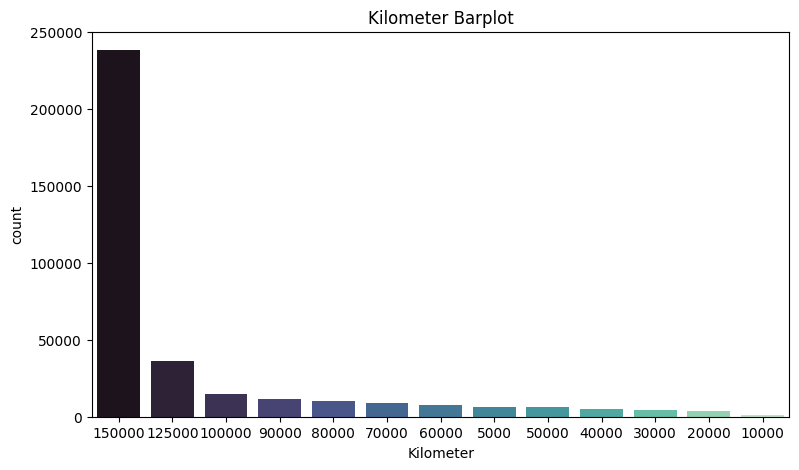



Number of unique values: 13
Min 5000.0
Max 150000.0
Q25 125000.0
Q50 150000.0
Q75 150000.0
Mean 128211.1725
Zero 0
Negative 0




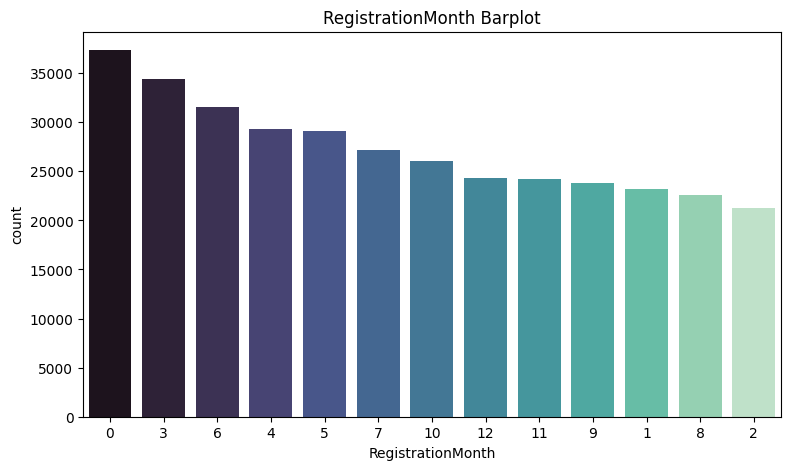



Number of unique values: 13
Min 0.0
Max 12.0
Q25 3.0
Q50 6.0
Q75 9.0
Mean 5.7146
Zero 37352
Negative 0




C:\Users\ivand\AppData\Local\Temp\ipykernel_1436\4243532157.py:82: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


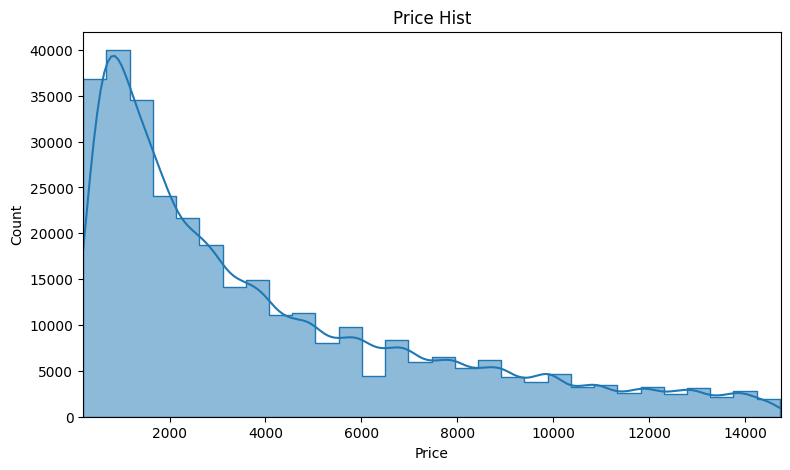



Number of unique values: 3731
Min 0.0
Max 20000.0
Q25 1050.0
Q50 2700.0
Q75 6400.0
Mean 4416.6568
Zero 10772
Negative 0




C:\Users\ivand\AppData\Local\Temp\ipykernel_1436\4243532157.py:82: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


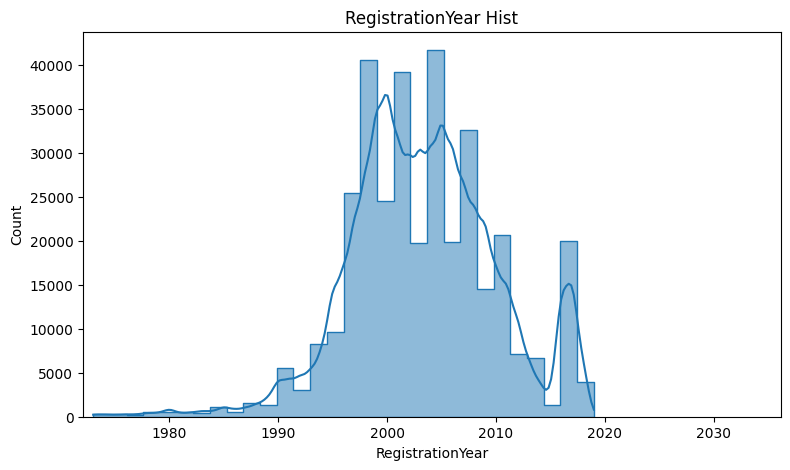



Number of unique values: 151
Min 1000.0
Max 9999.0
Q25 1999.0
Q50 2003.0
Q75 2008.0
Mean 2004.2344
Zero 0
Negative 0




C:\Users\ivand\AppData\Local\Temp\ipykernel_1436\4243532157.py:82: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


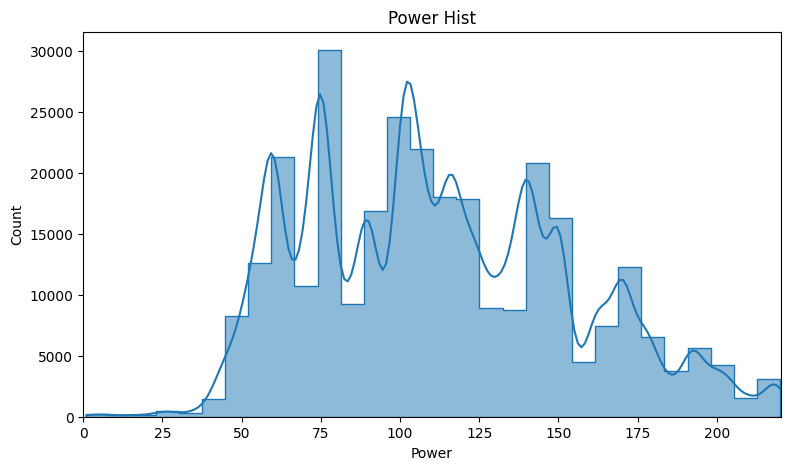



Number of unique values: 712
Min 0.0
Max 20000.0
Q25 69.0
Q50 105.0
Q75 143.0
Mean 110.0943
Zero 40225
Negative 0




 =================== Statistics by categorical feature ==================== 




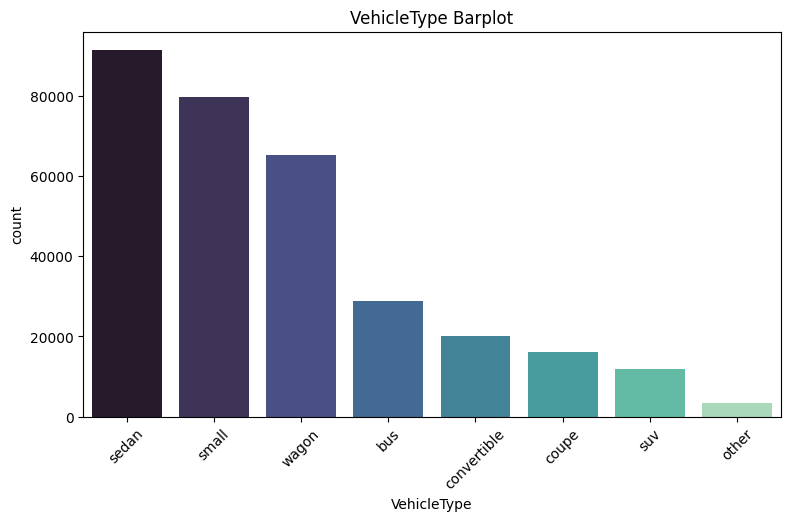



Number of unique values: 8




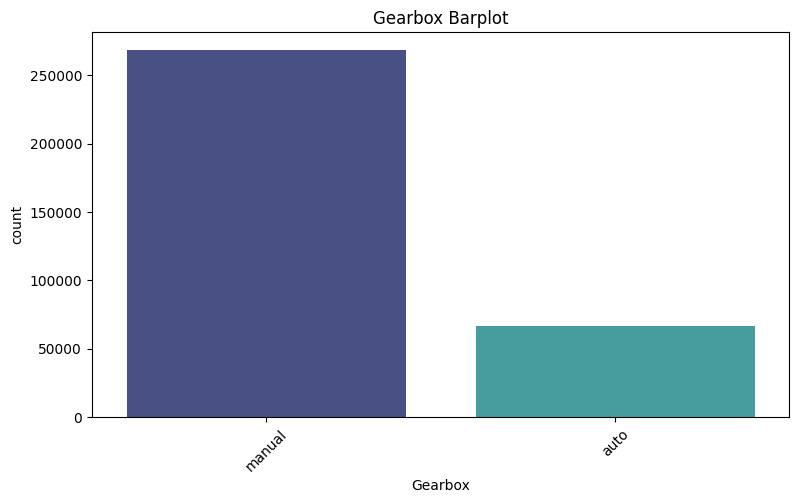



Number of unique values: 2




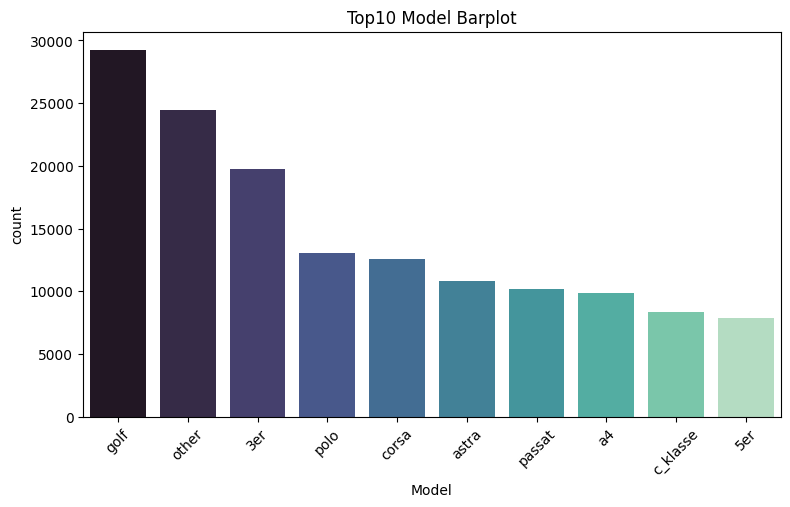



Number of unique values: 250




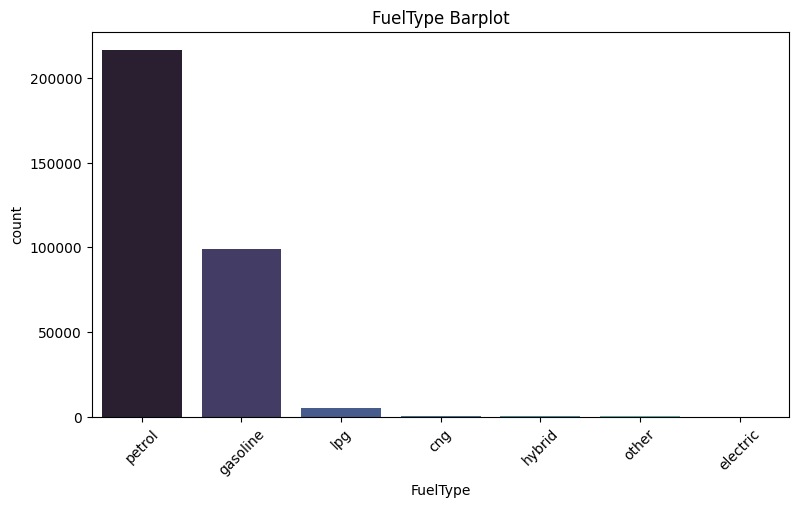



Number of unique values: 7




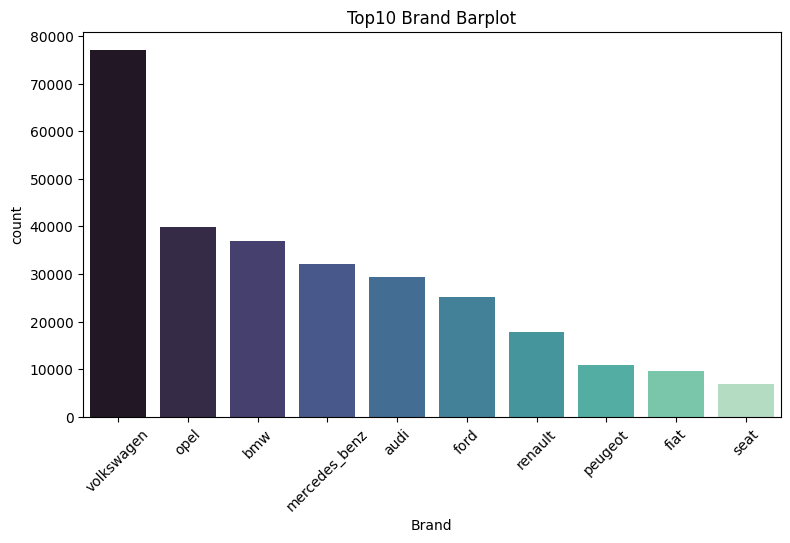



Number of unique values: 40




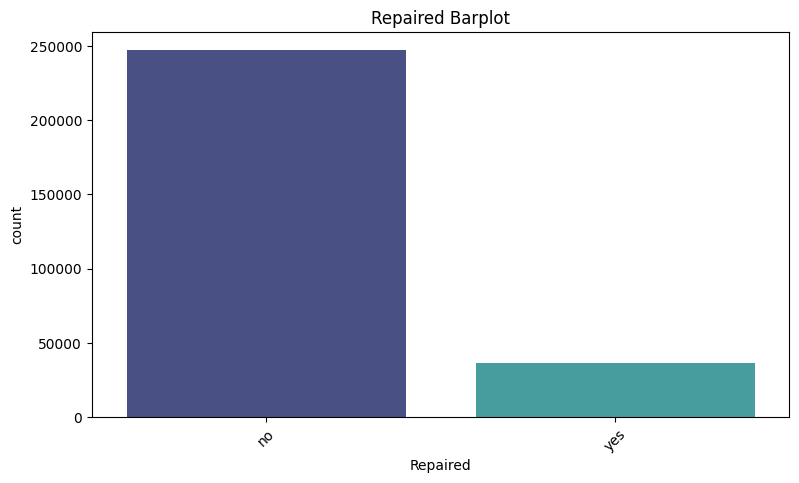



Number of unique values: 2




 ============================== Scatter plots ============================== 




C:\Users\ivand\AppData\Local\Temp\ipykernel_1436\4243532157.py:151: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(corrs), 2, i + 1)
C:\Users\ivand\AppData\Local\Temp\ipykernel_1436\4243532157.py:152: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=clmn1, y=clmn2, palette="light:b")
C:\Users\ivand\AppData\Local\Temp\ipykernel_1436\4243532157.py:152: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=clmn1, y=clmn2, palette="light:b")
C:\Users\ivand\AppData\Local\Temp\ipykernel_1436\4243532157.py:152: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=clmn1, y=clmn2, palette="light:b")
C:\Users\ivand\AppData\Local\Temp\ipykernel_1436\4243532157.py:152: UserWarning: Ignoring `palett

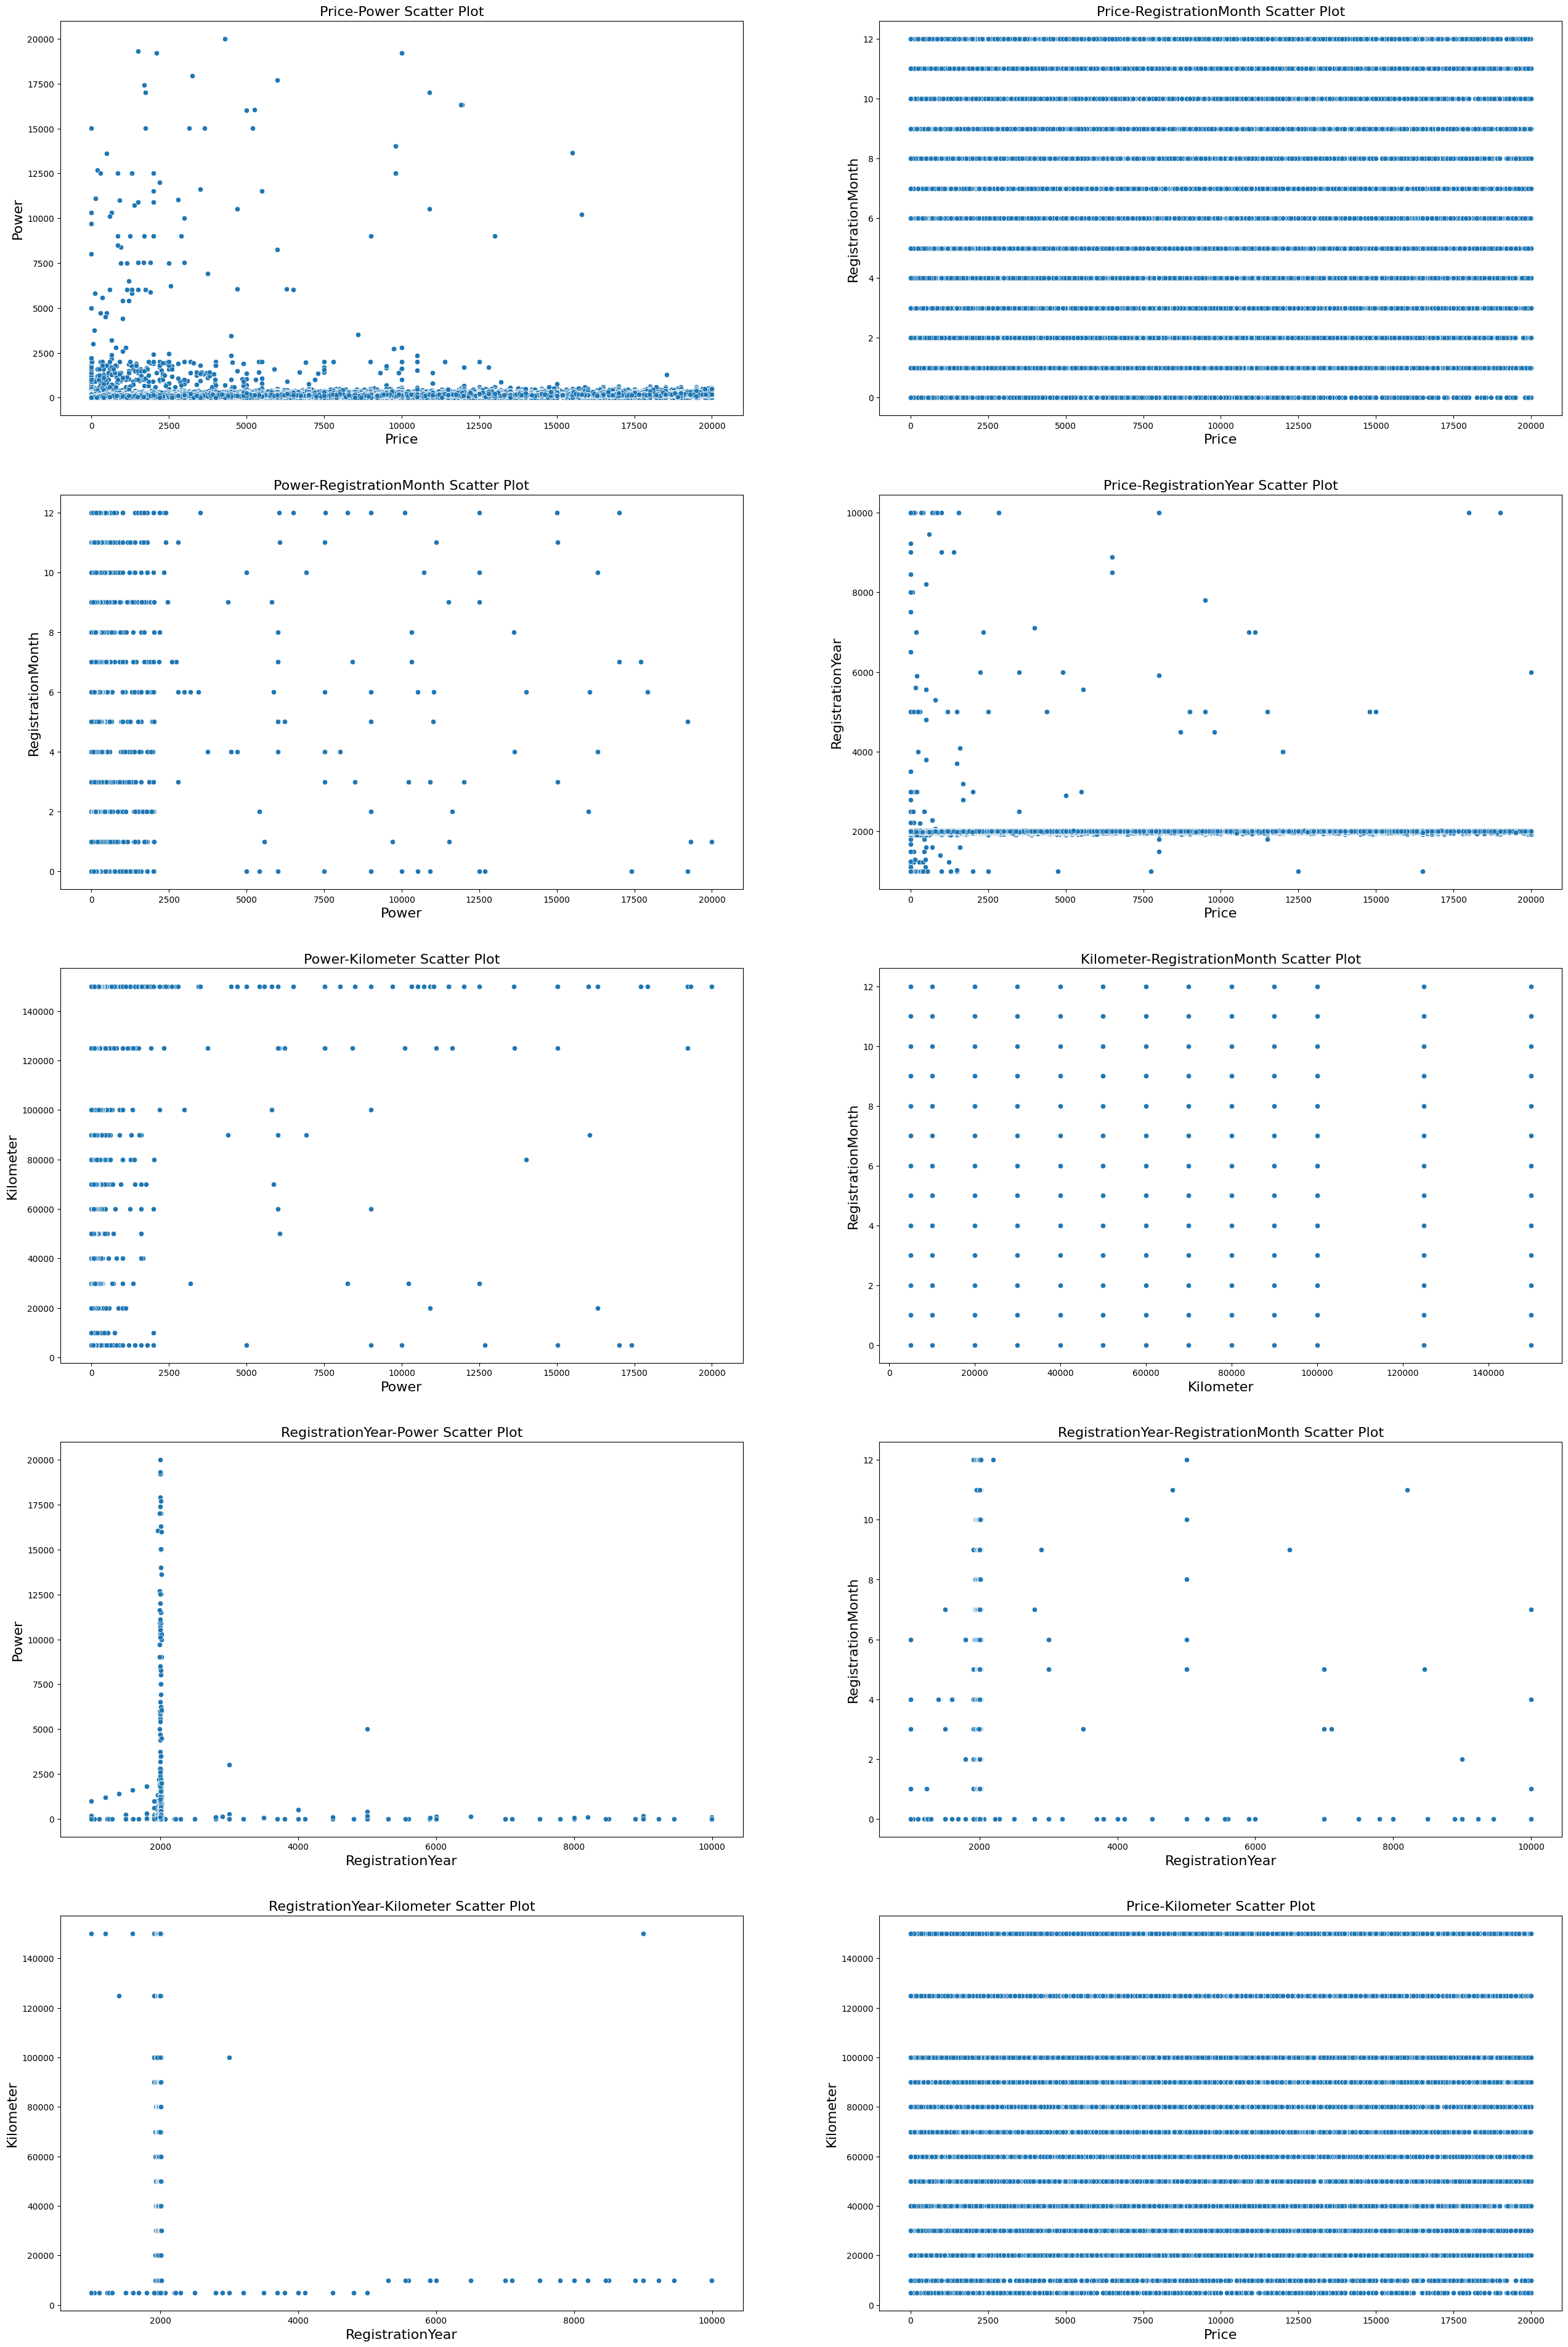





 ========================== Correlation heatmaps ========================== 




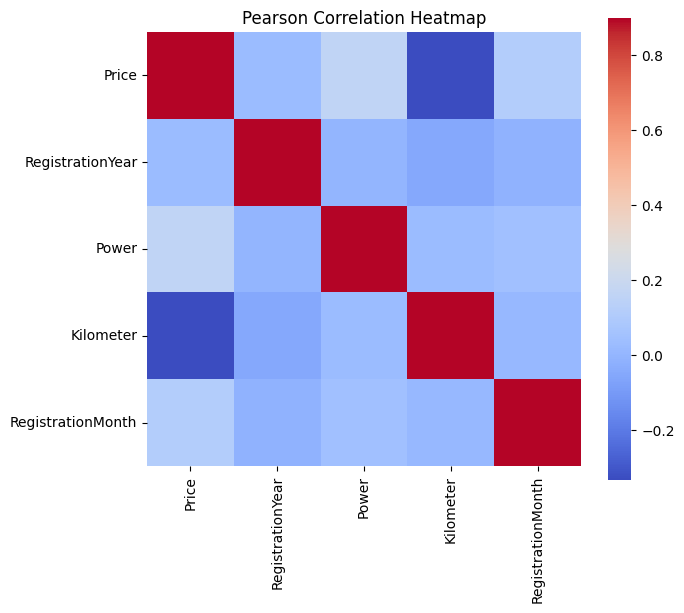

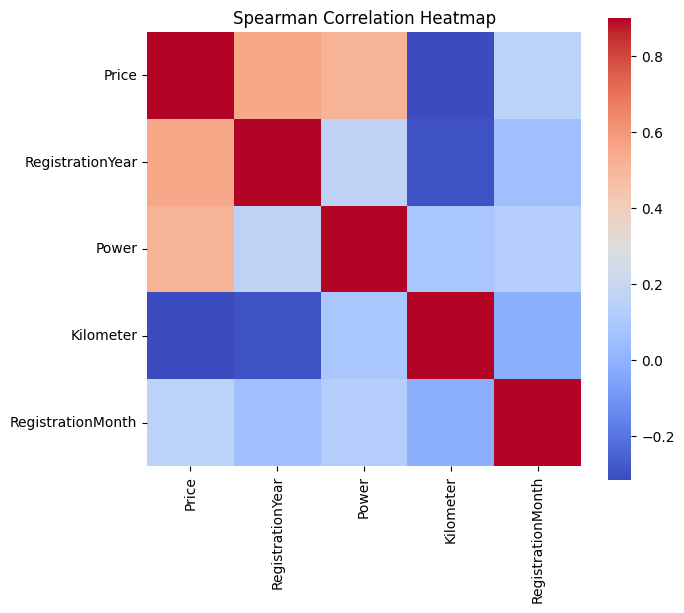




CPU times: total: 25.3 s
Wall time: 27.8 s


In [10]:
%%time

data_dissection(df)

В 5 столбцах потребуется обработка пропусков. В количественных признаках видны довольно сомнительные значения (к примеру, год 1000 и 9999, или же мощность 0) - необходима проверка на выбросы. Похоже, что мультиколлинеарность отсутствует 

## Предобработка данных


Для обучения модели будут применяться следующие признаки: `VehicleType`, `RegistrationYear`, `GearBox`, `Power`, `Model`, `Kilometer`, `FuelType`, `Brand`, `Repaired`. Такие признаки как `DateCrawled`, `RegistrationMonth`, `DateCreated`, `LastSeen` не помогут в обучении модели, но могут пригодиться во время предобработки, поэтому удалим их позже. 

### Названия колонок

В первую очередь заменим PascalCase на snake_case в названиях колонок

In [11]:
for i, column in enumerate(df.columns):
    df.rename(
        columns={
            df.columns[i]: "_".join(re.findall("[A-Z][^A-Z]*", df.columns[i])).lower()
        },
        inplace=True,
    )

In [12]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'last_seen'],
      dtype='object')

### Обработка пропусков

#### Столбец `fuel_type`

Посмотрим, какие уникальные значения существуют в столбце.

In [13]:
df.fuel_type.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Помимо пропусков настораживают пары 'petrol' - 'gasoline' и 'lpg' - 'cng'.  
Первом случае понятия синонимичны, разница лишь в том, что 'petrol' пришло из UK, в то время как 'gasoline' типично для USA. Поэтому можно оставить лишь один вариант - заменим 'gasoline' на 'petrol'. 
Во втором же случае понятия определяют виды газового топлива, поэтому остаются оба варианта. 

In [14]:
df.loc[df.fuel_type == "gasoline", "fuel_type"] = "petrol"

Объединим данные в сводную таблицу, в которой для каждой связки бренд+модель будет рассчитано число строк с определенным видом топлива.

In [15]:
fuel_type_pivot = (
    df.pivot_table(
        index=["brand", "model", "fuel_type"], values="price", aggfunc="count"
    )
    .reset_index()
    .rename(columns={"price": "count"})
)

In [16]:
fuel_type_pivot.head(10)

,brand,model,fuel_type,count
0,alfa_romeo,145,petrol,44
1,alfa_romeo,147,lpg,18
2,alfa_romeo,147,petrol,523
3,alfa_romeo,156,lpg,15
4,alfa_romeo,156,petrol,555
5,alfa_romeo,159,petrol,198
6,alfa_romeo,other,lpg,1
7,alfa_romeo,other,petrol,491
8,alfa_romeo,spider,lpg,1
9,alfa_romeo,spider,petrol,179


Определим, существуют ли случаи, когда значение модель отвечает нескольким брендам. 

In [17]:
%%time

for model in df[df.fuel_type.isna()].model.unique():
    if len(df[df.model == model].brand.unique()) > 1:
        print(f'Модель: {model}, бренды: {df[df.model == model].brand.unique()}')

Модель: other, бренды: ['volkswagen' 'mercedes_benz' 'hyundai' 'seat' 'honda' 'mitsubishi' 'opel'
 'fiat' 'suzuki' 'lancia' 'mazda' 'nissan' 'toyota' 'chevrolet' 'renault'
 'peugeot' 'kia' 'citroen' 'bmw' 'ford' 'chrysler' 'audi' 'jaguar' 'skoda'
 'porsche' 'rover' 'smart' 'saab' 'alfa_romeo' 'mini' 'volvo' 'trabant'
 'lada' 'daewoo' 'jeep' 'daihatsu' 'subaru' 'dacia' 'land_rover']
Модель: 3_reihe, бренды: ['mazda' 'peugeot']
Модель: 1_reihe, бренды: ['mazda' 'peugeot']
Модель: freelander, бренды: ['land_rover' 'rover']
Модель: matiz, бренды: ['chevrolet' 'daewoo']
Модель: 5_reihe, бренды: ['mazda' 'peugeot']
Модель: grand, бренды: ['jeep' 'suzuki' 'chrysler']
Модель: defender, бренды: ['land_rover' 'rover']
Модель: discovery, бренды: ['land_rover' 'rover']
CPU times: total: 4.78 s
Wall time: 5.32 s


К сожалению, по одной лишь модели надежно идентифицировать автомобиль нельзя. Но зато мы видим еще другую проблему датасета. Бренды rover и land_rover - это одно и то же, нужно заменить все роверы на лендроверы.

In [18]:
df.loc[df.brand == "rover", "brand"] = "land_rover"

Теперь заполним пропуски.
Для этого созданам функцию, которая принимает обрабатываемый датафрейм, столбец, в котором заполняются пропуски, и сводную таблицу, по которой эти пропуски заполняются. 

In [19]:
%%time

na_killer(df, 'fuel_type', fuel_type_pivot)

CPU times: total: 28.1 s
Wall time: 29.5 s


In [20]:
df.fuel_type.isna().sum()

7163

Удалось заполнить большую часть пропусков. Оставшиеся заполним значением 'unknown'.

In [21]:
df.fuel_type = df.fuel_type.fillna("unknown")

#### Столбец `vehicle_type`

Столбец `vehicle_type` похож на `fuel_type`, поэтому подход в обработке пропусков тот же.

In [22]:
df.vehicle_type.isna().sum()

37490

In [23]:
vehicle_type_pivot = (
    df.pivot_table(
        index=["brand", "model", "vehicle_type"], values="price", aggfunc="count"
    )
    .reset_index()
    .rename(columns={"price": "count"})
)

In [24]:
vehicle_type_pivot.head(10)

,brand,model,vehicle_type,count
0,alfa_romeo,145,coupe,2
1,alfa_romeo,145,other,1
2,alfa_romeo,145,sedan,13
3,alfa_romeo,145,small,19
4,alfa_romeo,147,coupe,27
5,alfa_romeo,147,other,7
6,alfa_romeo,147,sedan,358
7,alfa_romeo,147,small,97
8,alfa_romeo,147,suv,1
9,alfa_romeo,147,wagon,2


In [25]:
%%time

na_killer(df, 'vehicle_type', vehicle_type_pivot)

CPU times: total: 28.7 s
Wall time: 29.9 s


In [26]:
df.vehicle_type.isna().sum()

6828

In [27]:
df.vehicle_type = df.vehicle_type.fillna("unknown")

#### Столбец `Gearbox`

In [28]:
df.gearbox.isna().sum()

19833

Посмотрим, можно ли заполнить все пропуски значением manual.

In [29]:
gb_pivot = (
    df.pivot_table(index=["model", "brand", "gearbox"], values="price", aggfunc="count")
    .reset_index()
    .rename(columns={"price": "count"})
)

In [30]:
gb_pivot.head()

,model,brand,gearbox,count
0,100,audi,auto,63
1,100,audi,manual,336
2,145,alfa_romeo,manual,40
3,147,alfa_romeo,auto,29
4,147,alfa_romeo,manual,520


In [31]:
auto_gb = []
errors_gb_auto = []
errors_gb_manual = []
for model in gb_pivot.model.unique():
    try:
        if max(
            gb_pivot.loc[
                (gb_pivot.model == model) & (gb_pivot.gearbox == "auto"), "count"
            ]
        ) > max(
            gb_pivot.loc[
                (gb_pivot.model == model) & (gb_pivot.gearbox == "manual"), "count"
            ]
        ):
            auto_gb.append(model)
    except:
        if gb_pivot[gb_pivot.model == model].gearbox.unique() == "auto":
            errors_gb_auto.append(model)
        else:
            errors_gb_manual.append(model)
if len(auto_gb) > 0:
    print(
        f"Заполнение всех пропусков в столбце gearbox значением manual не рекомендуется, поскольку число автомобилей, для которых более типична коробка-автомат равно {len(auto_gb)}."
    )
if len(errors_gb_auto) > 0 or len(errors_gb_manual) > 0:
    print(
        f"\nАвтомобилей, представленных только с коробкой auto - {len(errors_gb_auto)}, с коробкой manual - {len(errors_gb_manual)}.\n\n"
    )

Заполнение всех пропусков в столбце gearbox значением manual не рекомендуется, поскольку число автомобилей, для которых более типична коробка-автомат равно 33.

Автомобилей, представленных только с коробкой auto - 2, с коробкой manual - 13.




In [32]:
%%time

na_killer(df, 'gearbox', gb_pivot)

CPU times: total: 28 s
Wall time: 29.7 s


In [33]:
df.gearbox.isna().sum()

4131

In [34]:
df.gearbox = df.gearbox.fillna("unknown")

In [35]:
df.gearbox.isna().sum()

0

#### Столбец `repaired`

Данный столбец обладает наибольшим числом пропусков, значительно превосходя по этому параметру прочие столбцы. Это наталкивает на мысль, что скорее всего этот признак являлся необязательной строкой в объявлении, а значит отсутствия значения можно считать ответом "нет, автомобиль не был в ремонте". Тогда пропуски можно заполнить отрицательным ответом.

In [36]:
df.repaired = df.repaired.fillna("no")

#### Столбец `model`

Восстановить информацию, какая модель была указана, практически невозможно. К тому же, заполнение может внести искажения в данные. Поэтому заполним пропуски значением `unknown`.

In [37]:
df.model = df.model.fillna("unknown")

### Дополнительная обработка

#### Столбец `brand`

In [38]:
df.brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'land_rover', 'lada'], dtype=object)

Встречается название 'sonstige_autos', которое означает 'прочие бренды'. Переведем значение на английский язык, заменив на 'other'.

In [39]:
df.loc[df.brand == "sonstige_autos", "brand"] = "other"

Evoque встречается во всем датафрейме лишь дважды, поэтому мешает OHE во время кросс-валидации: возникают случаи, когда значение не кодируется в тренировочной выборке, но появляется в валидационной.  

In [40]:
df = df.drop(axis=0, index=df[df.model == "range_rover_evoque"].index)

#### Столбец `model`

Заменим немецкие 'klasse', '-er', 'serie' и 'reihe' в названиях моделей на 'class' и 'series'.

In [41]:
for i, model in enumerate(df.model.unique()):
    if "reihe" in model:
        df.loc[df.model == model, "model"] = (
            "_".join(re.findall("[0-9 | a-z]*[_]", model)) + "series"
        )
    elif "klasse" in model:
        df.loc[df.model == model, "model"] = (
            "_".join(re.findall("[0-9 | a-z]*[_]", model)) + "class"
        )
    elif re.findall("[0-9][e][r]", model):
        df.loc[df.model == model, "model"] = (
            "".join(re.findall("[0-9]", model)) + "_series"
        )
    elif re.findall("[s][e][r][i][e][_]", model):
        df.loc[df.model == model, "model"] = (
            "".join(re.findall("[0-9]", model)) + "_series"
        )

### Работа с аномалиями

Перед обработкой аномалий сохраним датафрейм с обработанными пропусками, но присутствующими аномалиями, чтобы позже построить на нем тестовую выборку. 

In [42]:
df_test = df.copy()

Рассмотрим аномалии в столбцах `price`, `registration_year`, `power`, `registration_month`

#### Столбец `power`

In [43]:
df.power.describe()

count    354367.000000
mean        110.093287
std         189.850427
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

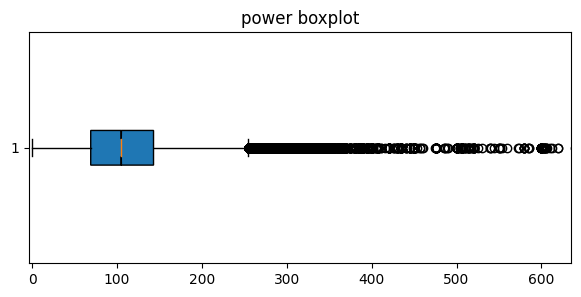

In [44]:
boxplot_builder(df, "power", 0.1, 2.5)

Разберемся с автомобилями, у которых мощность выше 450. Начнем с брендов, для которых высокие показатели мощности вполне допустимы. 

In [45]:
high_power_brands = ["porsche", "jaguar", "chrysler", "bmw", "mercedes_benz"]

In [46]:
df[
    (df.power < 700) & (df.power > 450) & (df.brand.isin(high_power_brands))
].sort_values(by="power", ascending=False)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,last_seen
184141,2016-04-05 00:06:18,17000,sedan,2004,auto,620,e_class,150000,2,petrol,mercedes_benz,no,2016-04-04,2016-04-05 12:29:38
13373,2016-03-31 12:38:14,18500,small,2002,auto,600,s_type,150000,12,petrol,jaguar,no,2016-03-31,2016-04-06 04:46:34
162460,2016-03-16 11:37:02,12000,sedan,2002,auto,600,s_type,150000,12,petrol,jaguar,no,2016-03-16,2016-03-22 16:19:52
243042,2016-03-27 20:53:40,15900,sedan,2003,auto,600,s_class,150000,10,petrol,mercedes_benz,no,2016-03-27,2016-04-05 19:45:39
154600,2016-03-25 23:36:22,16500,sedan,2003,auto,600,unknown,150000,10,petrol,mercedes_benz,no,2016-03-25,2016-04-04 04:15:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196892,2016-03-16 15:52:48,11999,wagon,2003,auto,476,e_class,150000,10,petrol,mercedes_benz,no,2016-03-16,2016-03-27 01:17:45
211660,2016-04-02 15:43:22,19490,wagon,2004,auto,476,e_class,100000,4,petrol,mercedes_benz,no,2016-04-02,2016-04-06 14:16:47
354045,2016-03-22 20:48:48,20000,coupe,2006,auto,476,other,125000,7,petrol,mercedes_benz,no,2016-03-22,2016-03-24 05:16:02
168659,2016-03-09 05:04:32,50,small,2002,auto,457,3_series,150000,7,petrol,bmw,no,2016-03-09,2016-03-09 05:04:32


Для высокомощных автомобилей границей здравого смысла будет 620 л/с. Для остальных же автомобилей установим эту границу на уровне 450 л/с.

In [47]:
df = df.drop(
    axis=0, index=df[(df.power > 620) & (df.brand.isin(high_power_brands))].index
)

In [48]:
df = df.drop(
    axis=0, index=df[(df.power > 450) & ~(df.brand.isin(high_power_brands))].index
)

Также стоит обратить внимание на диапазон (1, 20) л/с. Скрыв самые малогабаритные "будки", удалим оставшиеся строки. 

In [49]:
df = df.drop(
    axis=0,
    index=df[(df.power > 0) & (df.power < 20) & (df.vehicle_type != "small")].index,
)

Также существуют строки, где значение мощности равно 0.

In [50]:
len(df[df.power == 0])

40225

И их много. Можно сказать, что 0 равносилен пропуску. Чтобы выделить для модели эти значения заменим 0 на -100. 

In [51]:
df.loc[df.power == 0, "power"] = -100

#### Столбец `registration_year`

In [52]:
df.registration_year.describe()

count    353702.000000
mean       2004.227050
std          89.807637
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

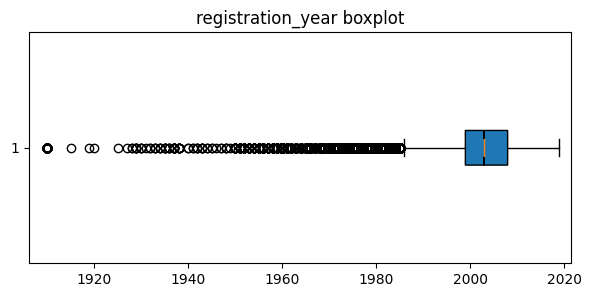

In [53]:
boxplot_builder(df, "registration_year", 0.96, 1)

Очень вряд ли, что автомобиль, представленный в датасете, был выпущен раньше, чем Ford Model T (Да, впервые в серию он пошел в 1908, но эмпирическим путем выяснено, что тогда в датасет лезут Mondeo 1910-го года). Удалим строки, где указан год ранее 1911-го.

In [54]:
len(df[df.registration_year < 1911])

155

In [55]:
df = df.drop(axis=0, index=df[df.registration_year < 1911].index)

Посмотрим на старичков, выпущенных с 1911 по 1949 год.

In [56]:
df[(df.registration_year > 1911) & (df.registration_year < 1950)].sort_values(
    by="registration_year", ascending=False
)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,last_seen
27525,2016-03-12 20:54:39,13300,sedan,1949,auto,99,other,60000,7,petrol,chrysler,no,2016-03-12,2016-04-05 15:47:32
271162,2016-03-27 08:37:16,8800,coupe,1948,manual,100,unknown,10000,7,petrol,other,no,2016-03-27,2016-04-07 05:45:14
246187,2016-04-05 23:06:32,0,unknown,1948,unknown,-100,unknown,5000,0,unknown,opel,no,2016-04-05,2016-04-05 23:25:18
63186,2016-03-08 20:50:10,17500,wagon,1948,manual,-100,unknown,60000,6,petrol,other,no,2016-03-08,2016-04-05 21:15:42
298981,2016-04-01 21:55:10,17800,coupe,1947,manual,-100,other,150000,0,petrol,ford,no,2016-04-01,2016-04-03 19:17:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299914,2016-03-12 08:36:21,16500,convertible,1927,manual,40,other,5000,5,petrol,ford,no,2016-03-12,2016-03-15 12:45:12
2273,2016-03-15 21:44:32,1800,convertible,1925,unknown,-100,unknown,5000,1,unknown,other,no,2016-03-15,2016-04-07 05:15:34
282912,2016-03-11 13:51:58,0,other,1920,unknown,-100,unknown,5000,1,other,other,no,2016-03-11,2016-04-07 09:45:59
197739,2016-04-01 09:39:11,0,other,1919,manual,-100,other,150000,6,petrol,ford,yes,2016-04-01,2016-04-01 09:39:11


Все выглядит правдобно, поэтому осталось удалить строки, где указан год и месяц старше 04.2016, поскольку все анкеты предствлены за март-апрель этого года. 

In [57]:
df = df.drop(axis=0, index=df[df.registration_year > 2016].index)
df = df.drop(
    axis=0, index=df[(df.registration_year == 2016) & (df.registration_month > 4)].index
)

In [58]:
df.registration_year.isna().sum()

0

#### Столбец `price`

In [59]:
df.price.describe()

count    334383.000000
mean       4502.974012
std        4557.078293
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

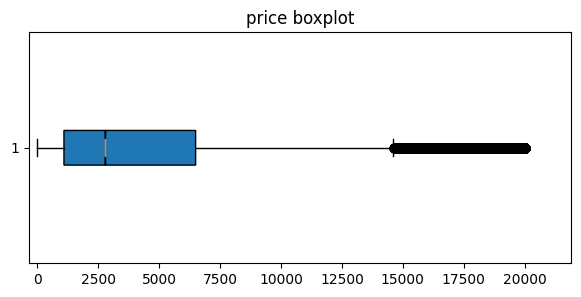

In [60]:
boxplot_builder(df, "price", 0.05, 1.5)

Поскольку неизвестно, в каком состоянии машины могут продаваться, будем считать что они должны быть минимально на ходу. Датасет явно имеет немецкие корни, значит автомобиль не может стоить дешевле 150 евро. Цена - целевой признак. Поэтому заполнять пропуски по нему не стоит. Удалим все строки, где указана цена менее 150 евро.

In [61]:
df = df.drop(axis=0, index=df[df.price < 150].index)

In [62]:
df.shape

(320781, 14)

## Создание выборок

In [63]:
feature_columns = [
    "vehicle_type",
    "registration_year",
    "gearbox",
    "power",
    "model",
    "kilometer",
    "fuel_type",
    "brand",
    "repaired",
]

In [64]:
X = df[feature_columns]
X.shape

(320781, 9)

In [65]:
X.sample(10, random_state=26)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
130690,sedan,2001,manual,60,micra,150000,petrol,nissan,no
110025,suv,2008,auto,239,touareg,100000,petrol,volkswagen,no
270347,sedan,1996,manual,125,a4,150000,petrol,audi,no
220013,small,2005,manual,88,2_series,125000,petrol,peugeot,no
201873,wagon,1999,manual,90,focus,150000,petrol,ford,no
268564,small,2016,manual,-100,fabia,150000,petrol,skoda,no
296246,sedan,1997,manual,55,megane,150000,petrol,renault,no
1500,sedan,2006,auto,334,a6,150000,petrol,audi,no
152681,wagon,2007,auto,150,3_series,150000,petrol,bmw,no
166568,sedan,2016,manual,-100,accord,70000,petrol,honda,no


In [66]:
y = df["price"]
y.shape

(320781,)

In [67]:
y.sample(10, random_state=26)

130690     1300
110025    10100
270347     1000
220013     1999
201873      950
268564     4850
296246      900
1500      13490
152681     6400
166568     1000
Name: price, dtype: int64

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=26
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((288702, 9), (32079, 9), (288702,), (32079,))

Теперь воспользуемся индексами созданной тестовой выборки, чтобы переопределить ее на основе датасета без обработки аномалий. 

In [69]:
X_test = df_test.loc[X_test.index, feature_columns]

In [70]:
y_test = df_test.loc[y_test.index, "price"]

## Построение пайплайнов

Создадим пайплайны для разных моделей. В качестве базовой простой модели будет использоваться линейная регрессия, для которой лучше подходит OHE. Еще одной стандартной моделью будет случайный лес с OE обработкой. Для LightGBM будем использовать OE, а CatBooost'у передадим данные как есть, поскольку данная модель сама справляется с строчными категориальными признаками. 

### Создание пайплайна для линейной модели

In [71]:
categorical_cols = X.drop(columns=["kilometer", "power", "registration_year"]).columns
numeric_cols = ["kilometer", "power", "registration_year"]

In [72]:
linear_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(sparse=False, drop="first"), categorical_cols),
        ("std", StandardScaler(), numeric_cols),
    ]
)

In [73]:
lr_pipeline = Pipeline([("ohe", linear_transformer), ("lr", LinearRegression())])

In [74]:
X_lr_trans = lr_pipeline[:1].fit_transform(X_train)
pd.DataFrame(X_lr_trans, columns=lr_pipeline[0].get_feature_names_out()).head()

c:\workspace\yandex_cources\full_history\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,ohe__vehicle_type_convertible,ohe__vehicle_type_coupe,ohe__vehicle_type_other,ohe__vehicle_type_sedan,ohe__vehicle_type_small,ohe__vehicle_type_suv,ohe__vehicle_type_unknown,ohe__vehicle_type_wagon,ohe__gearbox_manual,ohe__gearbox_unknown,ohe__model_145,ohe__model_147,ohe__model_156,ohe__model_159,ohe__model_1_series,ohe__model_200,ohe__model_2_series,ohe__model_300c,ohe__model_3_series,ohe__model_4_series,ohe__model_500,ohe__model_5_series,ohe__model_601,ohe__model_6_series,ohe__model_7_series,ohe__model_80,ohe__model_850,ohe__model_90,ohe__model_900,ohe__model_9000,ohe__model_911,ohe__model_a1,ohe__model_a2,ohe__model_a3,ohe__model_a4,ohe__model_a5,ohe__model_a6,ohe__model_a8,ohe__model_a_class,ohe__model_accord,ohe__model_agila,ohe__model_alhambra,ohe__model_almera,ohe__model_altea,ohe__model_amarok,ohe__model_antara,ohe__model_arosa,ohe__model_astra,ohe__model_auris,ohe__model_avensis,...,ohe__model_z_series,ohe__model_zafira,ohe__fuel_type_electric,ohe__fuel_type_hybrid,ohe__fuel_type_lpg,ohe__fuel_type_other,ohe__fuel_type_petrol,ohe__fuel_type_unknown,ohe__brand_audi,ohe__brand_bmw,ohe__brand_chevrolet,ohe__brand_chrysler,ohe__brand_citroen,ohe__brand_dacia,ohe__brand_daewoo,ohe__brand_daihatsu,ohe__brand_fiat,ohe__brand_ford,ohe__brand_honda,ohe__brand_hyundai,ohe__brand_jaguar,ohe__brand_jeep,ohe__brand_kia,ohe__brand_lada,ohe__brand_lancia,ohe__brand_land_rover,ohe__brand_mazda,ohe__brand_mercedes_benz,ohe__brand_mini,ohe__brand_mitsubishi,ohe__brand_nissan,ohe__brand_opel,ohe__brand_other,ohe__brand_peugeot,ohe__brand_porsche,ohe__brand_renault,ohe__brand_saab,ohe__brand_seat,ohe__brand_skoda,ohe__brand_smart,ohe__brand_subaru,ohe__brand_suzuki,ohe__brand_toyota,ohe__brand_trabant,ohe__brand_volkswagen,ohe__brand_volvo,ohe__repaired_yes,std__kilometer,std__power,std__registration_year
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.582675,0.006959,-0.372831
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.090171,3.088825,0.079328
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.582675,1.261632,-0.975709
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.582675,1.432170,0.531486
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.090171,-2.441480,-0.071392


### Создание пайплайнов для моделей деревьев

In [75]:
tree_transformer = ColumnTransformer(
    [("oe", OrdinalEncoder(), categorical_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [76]:
rf_pipeline = Pipeline([("oe", tree_transformer), ("rf", RandomForestRegressor())])

In [77]:
cat_pipeline = Pipeline([("cat", CatBoostRegressor())])

In [78]:
lgbm_pipeline = Pipeline([("oe", tree_transformer), ("lgbm", LGBMRegressor())])

## Обучение моделей

### Создание оценщика

In [79]:
def rmse_score(predictions, targets):
    return mean_squared_error(targets, predictions, squared=False)

### Гипер-параметры моделей

In [80]:
lr_params = {}

In [81]:
rf_params = {
    "rf__n_estimators": range(100, 300),
    "rf__max_depth": range(10, 18),
    "rf__random_state": [26],
    "rf__max_features": [1, "sqrt", "log2", None],
}

In [82]:
cat_params = {
    "cat__depth": range(3, 8),
    "cat__learning_rate": [0.3],
    "cat__iterations": range(50, 300),
}

In [83]:
lgbm_params = {
    "lgbm__n_estimators": range(100, 300),
    "lgbm__max_depth": range(8, 16),
    "lgbm__num_leaves": range(15, 45),
    "lgbm__reg_lambda": np.arange(0.1, 0.7, 0.1),
    "lgbm__reg_alpha": np.arange(0.1, 0.7, 0.1),
}

### LinearRegression

In [84]:
lr_search = RandomizedSearchCV(
    lr_pipeline,
    lr_params,
    n_iter=1,
    scoring="neg_root_mean_squared_error",
    n_jobs=4,
    random_state=26,
    error_score="raise",
)

In [85]:
%%time

lr_model = lr_search.fit(X_train, y_train)

c:\workspace\yandex_cources\full_history\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CPU times: total: 19.1 s
Wall time: 40.7 s


In [86]:
abs(lr_model.best_score_)

2804.541363021709

### RandomForestRegressor

In [87]:
rf_search = RandomizedSearchCV(
    rf_pipeline,
    rf_params,
    n_iter=10,
    scoring="neg_root_mean_squared_error",
    n_jobs=4,
    random_state=26,
    error_score="raise",
)

In [88]:
%%time

rf_model = rf_search.fit(X_train, y_train)

CPU times: total: 1min 2s
Wall time: 16min 16s


In [89]:
abs(rf_model.best_score_)

1593.2780356684093

### LightGBMRegressor

In [90]:
lgbm_search = RandomizedSearchCV(
    lgbm_pipeline,
    lgbm_params,
    n_iter=30,
    scoring="neg_root_mean_squared_error",
    n_jobs=4,
    random_state=26,
    error_score="raise",
)

In [91]:
%%time

lgbm_model = lgbm_search.fit(X_train, y_train)

CPU times: total: 32.2 s
Wall time: 1min 37s


In [92]:
abs(lgbm_model.best_score_)

1620.4524859416383

### CatBoostRegressor

In [93]:
cat_search = RandomizedSearchCV(
    cat_pipeline,
    cat_params,
    n_iter=10,
    scoring="neg_root_mean_squared_error",
    n_jobs=4,
    random_state=26,
    error_score="raise",
)

In [94]:
%%time

cat_model = cat_search.fit(X_train, y_train, cat__cat_features=categorical_cols.to_list(), cat__verbose=50)

0:	learn: 3682.1562543	total: 317ms	remaining: 1m 13s
50:	learn: 1708.9226976	total: 8.9s	remaining: 31.6s
100:	learn: 1639.0836412	total: 18s	remaining: 23.4s
150:	learn: 1605.9545156	total: 26.8s	remaining: 14.4s
200:	learn: 1582.0376059	total: 35.3s	remaining: 5.45s
231:	learn: 1569.2632681	total: 40.7s	remaining: 0us
CPU times: total: 47.5 s
Wall time: 9min 22s


In [95]:
abs(cat_model.best_score_)

1637.0334564904522

## Скорость работы моделей

**LinearRegression**

Поскольку модель линейной регрессии обучалась без использования гипер-параметров, время обучения мы уже знаем. Осталось узнать время, за которое модель сделает предсказание:  

In [96]:
%%timeit

lr_model.predict(X_test)

107 ms ± 558 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**RandomForestRegressor**

In [97]:
rf_test_model = Pipeline(
    [("oe", tree_transformer), ("rf", RandomForestRegressor())]
).set_params(**rf_model.best_params_)

In [98]:
%%timeit

rf_test_model.fit(X_train, y_train)

59.6 s ± 218 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [99]:
%%timeit

rf_test_model.predict(X_test)

1.64 s ± 56.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**LightGBMRegressor**

In [100]:
lgbm_test_model = Pipeline(
    [("oe", tree_transformer), ("lgbm", LGBMRegressor())]
).set_params(**lgbm_model.best_params_)

In [101]:
%%timeit

lgbm_test_model.fit(X_train, y_train)

1.69 s ± 60 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [102]:
%%timeit

lgbm_test_model.predict(X_test)

129 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**CatBoostRegressor**

In [103]:
cat_test_model = Pipeline(
    [("cat", CatBoostRegressor(cat_features=categorical_cols.to_list(), verbose=False))]
).set_params(**cat_model.best_params_)

In [104]:
%%timeit

cat_test_model.fit(X_train, y_train)

40.2 s ± 192 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [105]:
%%timeit

cat_test_model.predict(X_test)

98.5 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Проверка лучшей модели на тестовой выборке

In [106]:
%%time

lgbm_preds = lgbm_model.predict(X_test)

CPU times: total: 859 ms
Wall time: 120 ms


In [107]:
rmse_score(lgbm_preds, y_test)

1601.8166139564557

## Проверка Dummy-моделью

Dummy-модель является константной моделью, предсказанием которой служит среднее по всем ценам. 

In [108]:
dummy_params = {}
dummy_search = RandomizedSearchCV(
    DummyRegressor(),
    dummy_params,
    n_iter=1,
    scoring=make_scorer(rmse_score, greater_is_better=False),
    n_jobs=1,
    random_state=26,
    error_score="raise",
)

In [109]:
dummy_search.fit(X_train, y_train)

RandomizedSearchCV(error_score='raise', estimator=DummyRegressor(), n_iter=1,
                   n_jobs=1, param_distributions={}, random_state=26,
                   scoring=make_scorer(rmse_score, greater_is_better=False))

In [110]:
abs(dummy_search.best_score_)

4557.550376476074

Проверка на вменяемость пройдена.

## Общий вывод

**В ходе выполнения исследования** был рассмотрен датасет, содержащий информацию о технических характеристиках, комплектации и ценах различных автомобилей, при помощи которого были обучены модели, предсказывающие стоимость автомобиля. 

**Выполнены следующие этапы:**  
- **Обзор данных**  
    Изучено содержимое датасета;
- **Предобработка данных**  
    Произведена обработка пропусков и аномалий;
- **Создание выборок**  
    Датасет разделен на тренировочную и тестовую выборки; тестовая выборка перестроина на основе частично предобработанного датасета с заполненными пропусками, но присутствующими аномалиями;
- **Построение пайплайнов**  
    Созданы пайплайны для различных моделей. Так, модель из библиотеки CatBoost не требует дополнительного кодирования данных, поскольку способна работать с категориальными величинами. Для моделей из библиотек LightGBM и sklearn построены пайплайны с подходящими кодировщиками;
- **Обучение моделей**  
    Подобраны оптимальные гипер-параметры при помощи RandomizedSearchCV, определена лучшая модель: ею оказалась модель из библиотеки LightGBM. Данная модель дает результаты, сопоставимые с классическим лесом деревьев и моделью CatBoost, однако время ее обучения значительно превосходит показатели других "деревянных" моделей. Лучший результат модели LightGBM:

In [111]:
abs(lgbm_model.best_score_)

1620.4524859416383

- **Проверка лучшей модели на тестовой выборке**  
    Показатели лучше модели подтверждены на тестовой выборке:

In [112]:
rmse_score(lgbm_preds, y_test)

1601.8166139564557

- **Проверка Dummy-моделью**  
    Проверка на вменяемость пройдена: по сравнению с Dummy-моделью, метрика RMSE улучшилась почти в 3 раза. 
    
**Испытание лучшей модели на скорость работы дало следующие результаты**

Время обучения: ~2 секунды

Время предсказания: ~150 мс